In [12]:
import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))

In [ ]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from tqdm import tqdm 


In [14]:
train_emb_path = "/nrs/turaga/jakob/implicit-neurons/ckpt/ae/paper_flywire_deepset_train_normed/emb_ep_90"
test_emb_path = "/nrs/turaga/jakob/implicit-neurons/ckpt/ae/paper_flywire_deepset_test/emb/"

label_mapping_path = "/nrs/turaga/jakob/implicit-neurons/flywire_full_v783/types/visual_neurons_id_to_family.json"
type_mapping_path = "/nrs/turaga/jakob/implicit-neurons/flywire_full_v783/types/visual_neurons_family_to_id.json"

In [15]:
def files_to_tensor(files):
    tensors = []
    for emb_file in tqdm(files):
        data = np.load(emb_file)
        data = np.expand_dims(data, axis=0)
        tensors.append(data)
    array = np.concatenate(tensors, axis=0)
    return array

In [16]:
def load_embeddings(path):
    emb_files = glob.glob(f"{path}/*emb.npy")
    label_files = glob.glob(f"{path}/*type.npy")

    print(f"Found {len(emb_files)} embeddings files")
    print(f"Found {len(label_files)} label files")

    emb = files_to_tensor(emb_files)
    labels = files_to_tensor(label_files)

    return emb, labels

In [17]:
label_to_type = json.load(open(label_mapping_path))
type_to_label = json.load(open(type_mapping_path))

print("Training Embeddings:")
train_emb, train_labels = load_embeddings(train_emb_path)

print("Test Embeddings:")
test_emb, test_labels = load_embeddings(test_emb_path)

Training Embeddings:
Found 14000 embeddings files
Found 14000 label files


  0%|          | 0/14000 [00:00<?, ?it/s]

100%|██████████| 14000/14000 [00:05<00:00, 2360.84it/s]


Test Embeddings:
Found 33054 embeddings files
Found 33054 label files


100%|██████████| 33054/33054 [00:12<00:00, 2672.85it/s]


In [18]:
unique_labels_train = np.unique(train_labels)
ol_types = [label_to_type[str(label)] for label in unique_labels_train]
print(unique_labels_train)
print(len(unique_labels_train))
print(ol_types)


[ 5  7  9 13 14 15 19 21 22 23 24 25 26 28 29 31 32 34 35 36 41 42 43 44
 45 46 47 48 49 50 51 54 55 56 60]
35
['Centrifugal', 'Lobula Medulla Amacrine', 'Distal Medulla', 'Lamina Monopolar', 'LC', 'LLPC', 'Lobula Medulla Tangential', 'LPC', 'LPLC', 'LPT', 'Lobula Plate Intrinsic', 'LT', 'Lamina Intrinsic', 'Lamina Wide Field', 'Lobula Intrinsic', 'Medulla Lobula Tangential', 'MT', 'MeMe', 'MeTu', 'Medulla Intrinsic', 'Proximal Medulla', 'Photo Receptors', 'Serpentine Medulla', 'T1 Neuron', 'T2 Neuron', 'T3 Neuron', 'T4 Neuron', 'T5 Neuron', 'Translobula Plate', 'Transmedullary', 'Transmedullary Y', 'Y Neuron', 'aMe', 'cL', 'cLP']


In [20]:
print(train_emb.shape)
print(train_labels.shape)

print(test_emb.shape)
print(test_labels.shape)

(14000, 32)
(14000, 1)
(33054, 32)
(33054, 1)


In [21]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_emb, train_labels)
y_pred = classifier.predict(test_emb)

# Evaluate the classifier
accuracy = np.mean(y_pred == test_labels.squeeze(-1))
print(f'Accuracy: {accuracy * 100:.2f}%')

/groups/turaga/home/troidlj/miniconda3/envs/implicit-neurons/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 81.47%


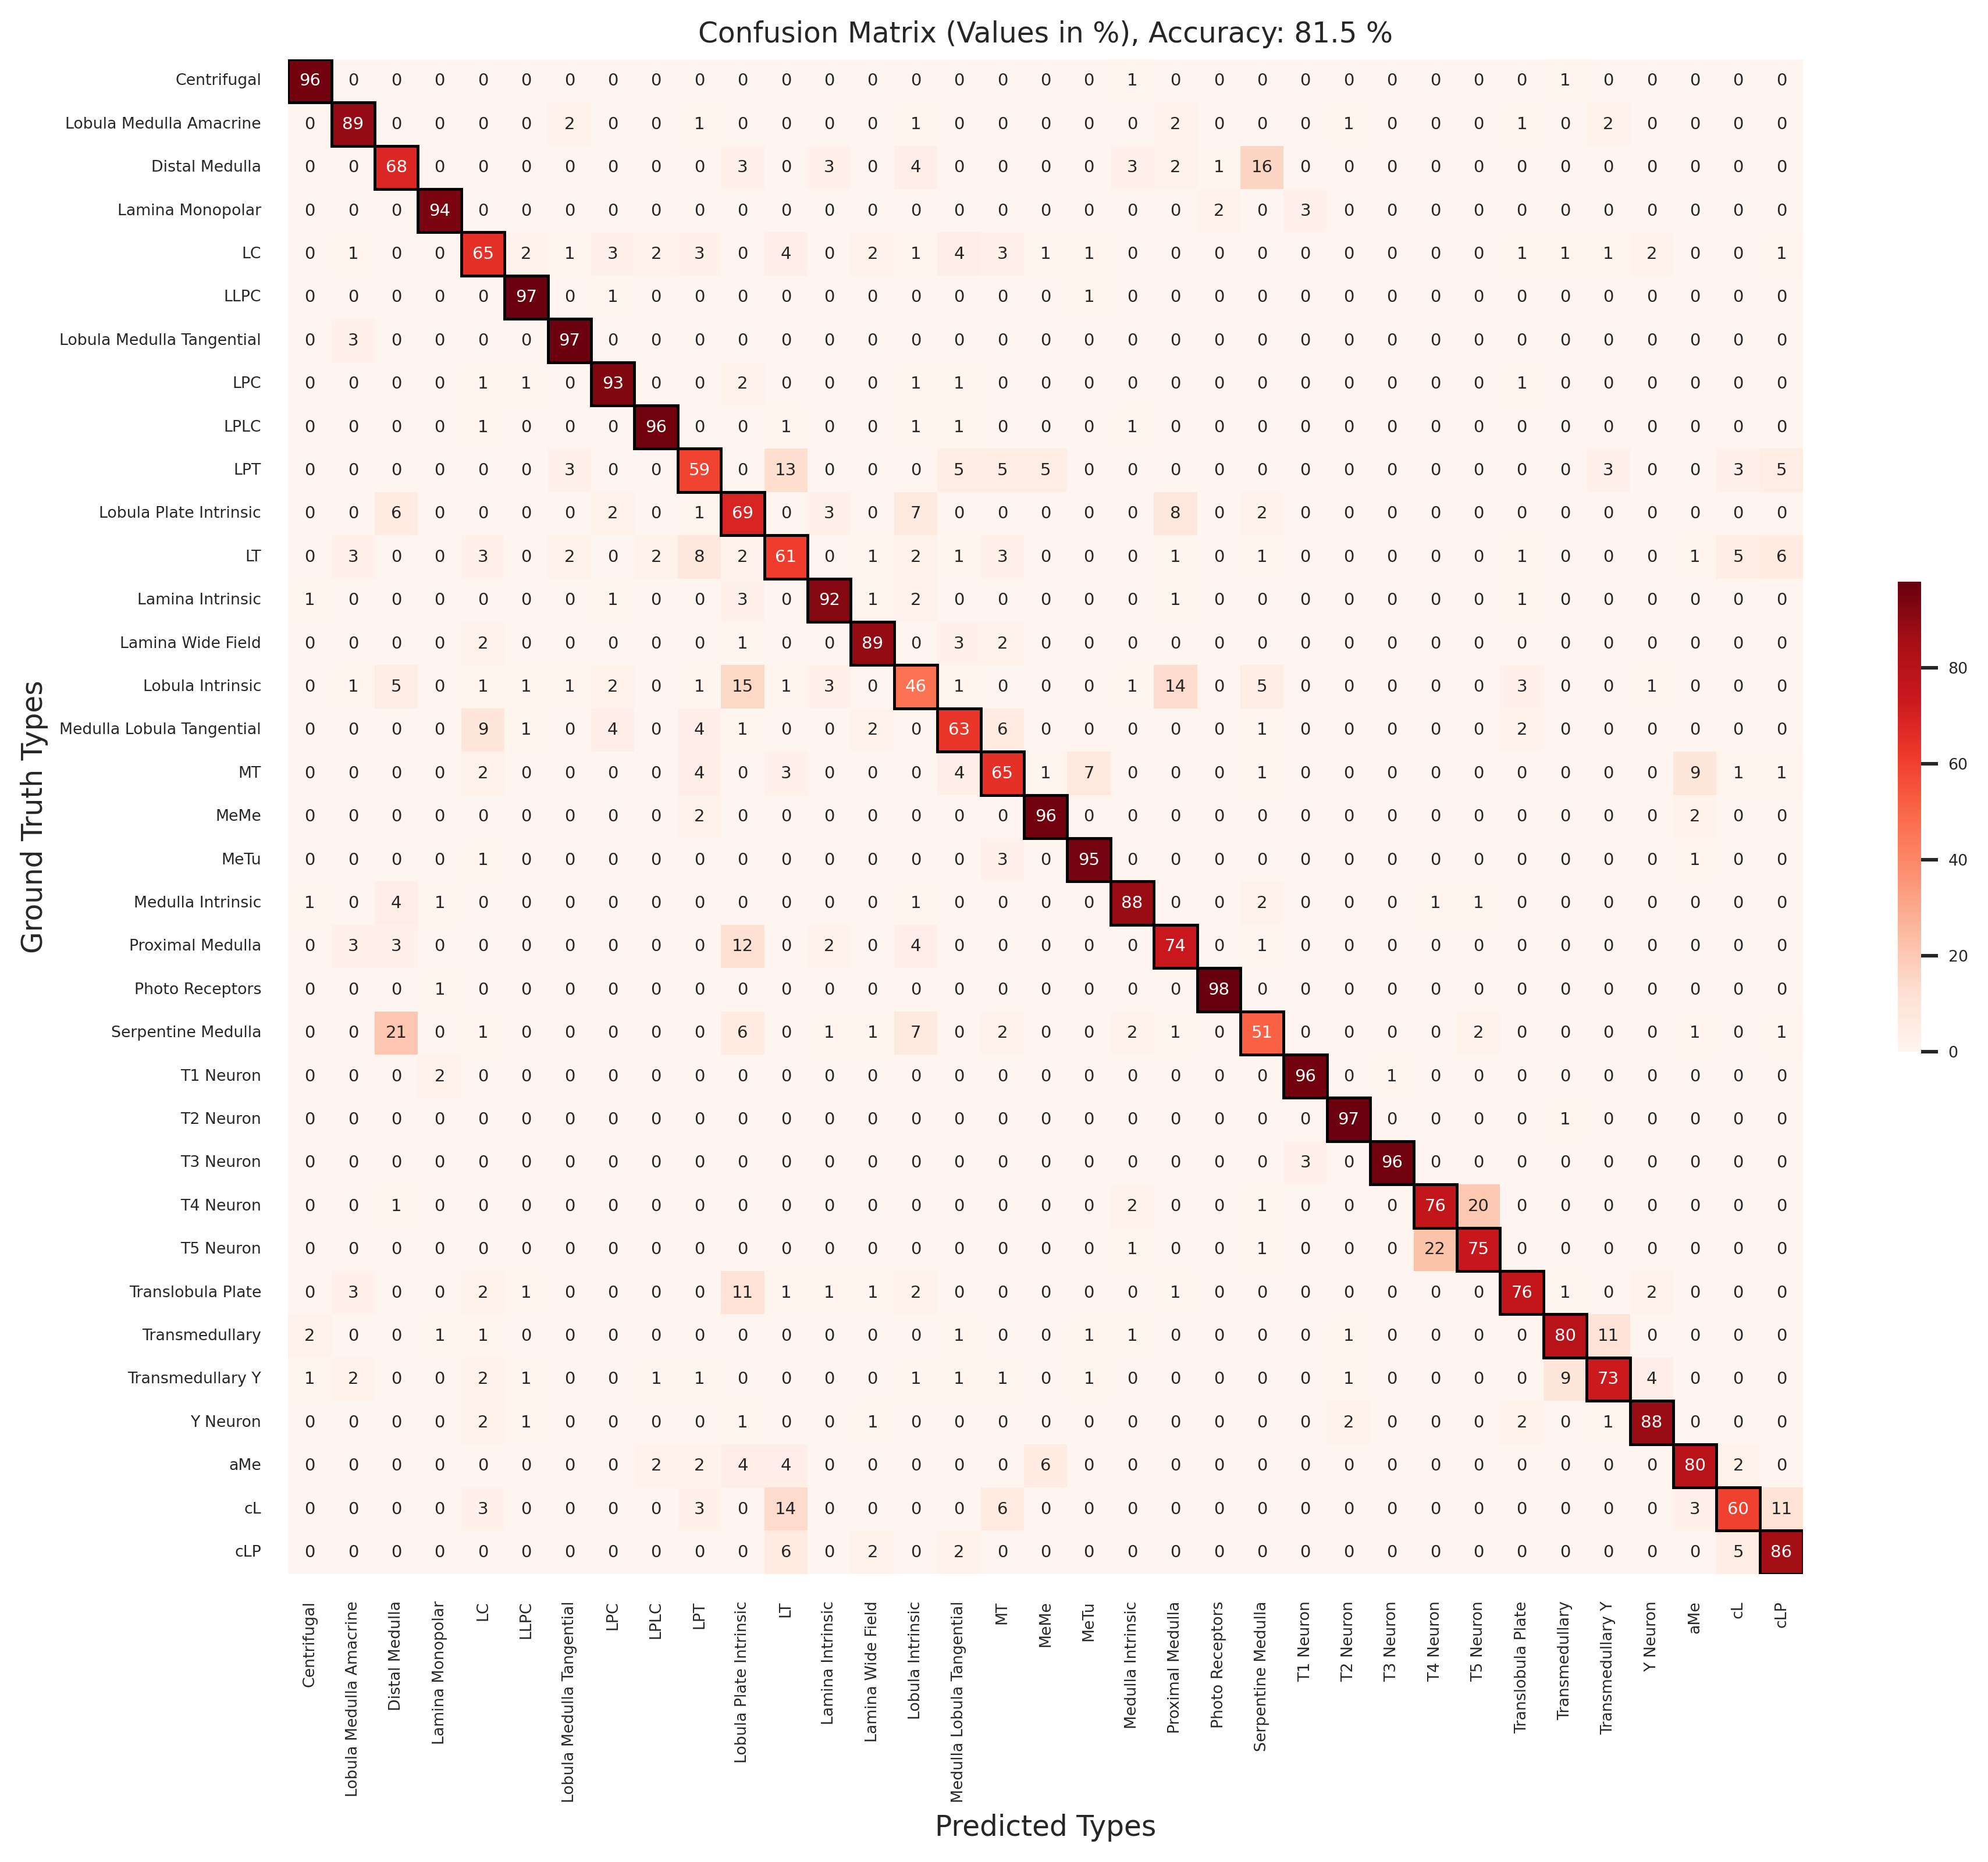

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm = cm.round(0)

# print(cm.sum(axis=1))

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 12), dpi=350)

sns.set_theme(font_scale=0.5)  # Change the font scale to make labels smaller
sns.heatmap(cm, cmap='Reds', annot=True, xticklabels=ol_types, yticklabels=ol_types, square=True, cbar_kws={'shrink': 0.25})
# Highlight the diagonal
for i in range(cm.shape[0]):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1))

plt.xlabel('Predicted Types', fontsize=10)
plt.ylabel('Ground Truth Types', fontsize=10)
plt.title('Confusion Matrix (Values in %), Accuracy: {} %'.format(round(accuracy * 100, 1)), fontsize=10)
plt.show()